In [1]:
import requests
from io import BytesIO
from PIL import Image

from torchvision import transforms
from transformers import OFATokenizer, OFAModel

from semshap.masking import generate_dff_masks
from semshap.plot import plot_masks

import torch.nn as nn
from semshap.explainers import BaseExplainer
from semshap.plot import barh, heatmap
import matplotlib.pyplot as plt

import torch

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

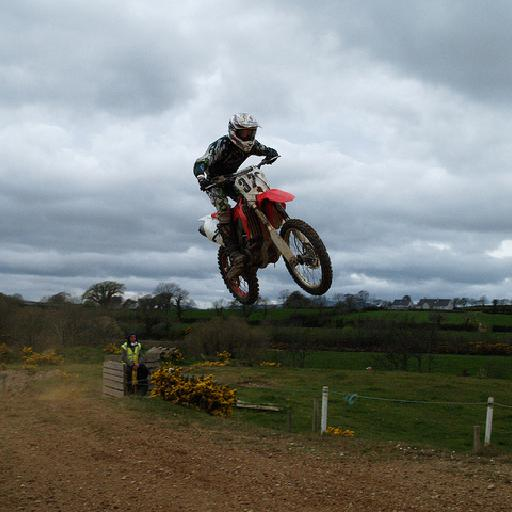

In [3]:
img_url ="https://marhamilresearch4.blob.core.windows.net/stego-public/sample_images/moto1.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img

In [20]:
ckpt_dir = "OFA-tiny"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
#image preprocessing
patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize(img.size, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# load the model
model = OFAModel.from_pretrained(ckpt_dir, use_cache=False).to(device)
tokenizer = OFATokenizer.from_pretrained(ckpt_dir)

/home/michele/PycharmProjects/vl-shap/venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


OFA-tiny
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


## Extract the visual embeddings and generate the DFF mask

In [22]:
with torch.no_grad():
    visual_embeds = model.encoder.embed_images(patch_resize_transform(img).unsqueeze(0).to(device))

visual_embeds = visual_embeds.detach().cpu().squeeze(0).permute(1, 2, 0)
visual_embeds.shape

torch.Size([32, 32, 1024])

In [23]:
out = generate_dff_masks(visual_embeds, k=10, img_size=img.size, mask_th=25, return_heatmaps=True)
masks = out['masks']

/home/michele/PycharmProjects/vl-shap/venv/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


(<Figure size 640x480 with 12 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
         <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
        [<Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
         <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
        [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
         <Axes: title={'center': '10'}>, <Axes: >]], dtype=object))

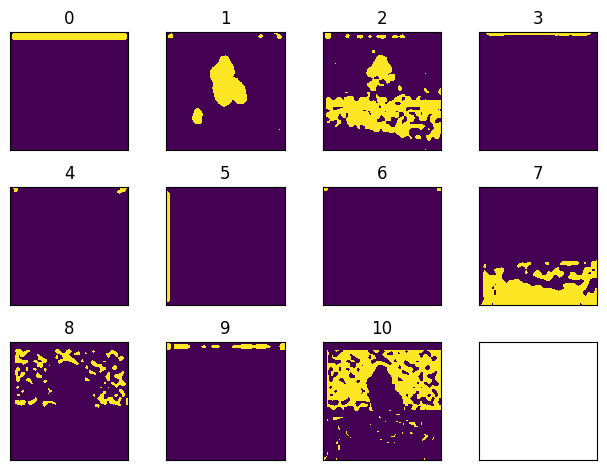

In [24]:
plot_masks(masks)

## Run the explainer

In [25]:
class ModelWrapper(nn.Module):
    def __init__(self, model, tokenizer, question, resolution, device="cpu"):
        super().__init__()
        
        self.resolution=resolution
        self.num_beams = 5
        self.no_repeat_ngram_size = 3
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.patch_resize_transform = transforms.Compose([
                                                            lambda image: image.convert("RGB"),
                                                            transforms.Resize(self.resolution, interpolation=Image.BICUBIC),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                                        ])
        
        self.inputs = tokenizer([question], return_tensors="pt").input_ids.to(self.device)
        
    

    def forward(self, img):
        # put here all to code to generate a caption from an image
        
        patch_img = self.patch_resize_transform(img).unsqueeze(0).to(self.device)
        out_ids = model.generate(self.inputs, patch_images=patch_img, num_beams=self.num_beams, 
                                 no_repeat_ngram_size=self.no_repeat_ngram_size)
        
        return tokenizer.batch_decode(out_ids, skip_special_tokens=True)[0]

In [26]:
question = "What is the subject doing?"
model_wrapper = ModelWrapper(model, tokenizer, question, resolution=img.size, device=device)

In [27]:
model_wrapper(img)

' riding a dirt bike'

In [28]:
explainer = BaseExplainer(model_wrapper, device=device)

(…)f3d3c277d6e90027e55de9125/.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

(…)7d6e90027e55de9125/1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(…)e2f80f3d3c277d6e90027e55de9125/README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

(…)f80f3d3c277d6e90027e55de9125/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

(…)de9125/config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

(…)d3c277d6e90027e55de9125/data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

(…)90027e55de9125/sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

(…)6e90027e55de9125/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

(…)f3d3c277d6e90027e55de9125/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(…)7d6e90027e55de9125/tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

(…)3d3c277d6e90027e55de9125/train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

(…)e2f80f3d3c277d6e90027e55de9125/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)80f3d3c277d6e90027e55de9125/modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [29]:
shap, base = explainer.explain(img, masks, k=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [01:48<00:00, 18.91it/s]


Text(0.5, 1.0, 'Brute force KernelSHAP')

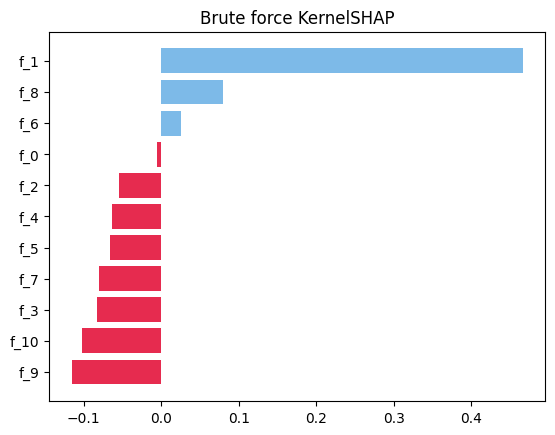

In [30]:
labels = [ f"f_{i}" for i in range(shap.shape[0]) ]
barh(labels, shap)

plt.title("Brute force KernelSHAP")

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f546a2e25c0>)

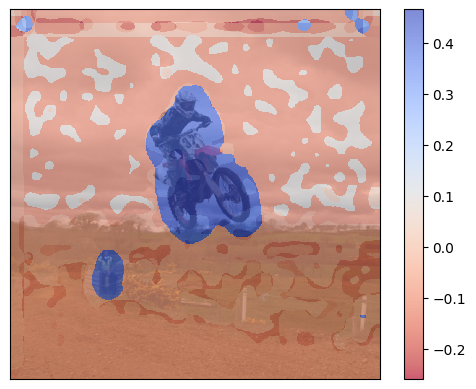

In [31]:
heatmap(img, masks, shap, alpha=0.65)

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f545c3414e0>)

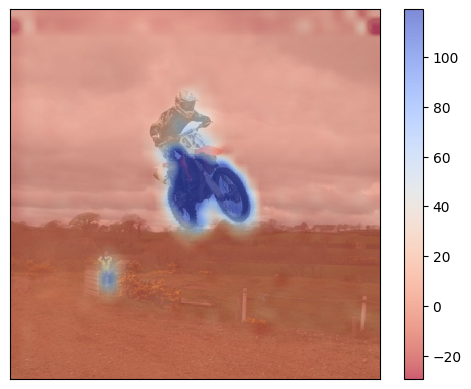

In [32]:
heatmap(img, out['heatmaps'], shap, alpha=0.65)